In [15]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import numpy as np
import geopandas as gpd 
from scipy.cluster import hierarchy
import sklearn.metrics as skm

%matplotlib inline

In [16]:
dict_ine_name= {'02': 'Albacete', '03': 'Alicante/Alacant', '04': 'Almería', '01': 'Araba/Álava', '33': 'Asturias', '05': 'Ávila', '06': 'Badajoz', '07': 'Balears Illes',
 '08': 'Barcelona', '48': 'Bizkaia', '09': 'Burgos', '10': 'Cáceres', '11': 'Cádiz', '39': 'Cantabria', '12': 'Castellón/Castelló', '13': 'Ciudad Real', '14': 'Córdoba',
 '15': 'Coruña A', '16': 'Cuenca', '20': 'Gipuzkoa', '17': 'Girona', '18': 'Granada', '19': 'Guadalajara', '21': 'Huelva', '22': 'Huesca', '23': 'Jaén', '24': 'León',
 '25': 'Lleida', '27': 'Lugo', '28': 'Madrid', '29': 'Málaga', '30': 'Murcia', '31': 'Navarra', '32': 'Ourense', '34': 'Palencia', '35': 'Palmas Las', '36': 'Pontevedra',
 '26': 'Rioja La', '37': 'Salamanca', '38': 'Santa Cruz de Tenerife', '40': 'Segovia', '41': 'Sevilla', '42': 'Soria', '43': 'Tarragona', '44': 'Teruel', '45': 'Toledo',
 '46': 'Valencia/València', '47': 'Valladolid', '49': 'Zamora', '50': 'Zaragoza', '51': 'Ceuta', '52': 'Melilla'}

In [17]:
dict_name_ine = {}
for k, v in dict_ine_name.items():
    dict_name_ine[v] = k

In [27]:
gdf = gpd.read_file('../Map/Provinces.shp', encoding='utf-8') 
gdf_points = gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].centroid
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')

In [28]:
def preprocess(path):
    dtypes = {"Origen":str,"Destino":str,"Año":str,"Mes":str,"Día":str,"Periodo":str,"Modo":str,"Distancia":str,"Residencia":str,"Actividad_Origen":str,"Actividad_Destino":str,
              "Viajeros":str,"Viajeros-km":str}
    df = pd.read_csv(path, encoding="utf-8", dtype=dtypes)
    df['Viajeros'] = df['Viajeros'].str.replace(r'\,','').astype(float)
    df['Viajeros-km'] = df['Viajeros-km'].str.replace(r'\,','').astype(float)
    df['Origen2'] = df['Origen'].apply(lambda z: z[:2])
    df['Destino2'] = df['Destino'].apply(lambda z: z[:2])
    return df

In [29]:
def get_destino_distribution(df,Origen):
    destino_distribution = df[df.Origen2 == Origen].groupby('Destino2').Viajeros.sum().to_frame('weight')
    destino_distribution.reset_index(inplace=True)
    df_all_destino = pd.DataFrame([str(z).zfill(2) for z in range(1, 53)], columns=['Destino2'])
    destino_distribution = destino_distribution.merge(df_all_destino, on='Destino2', how='outer')
    destino_distribution.weight.fillna(0, inplace=True)
    destino_distribution['norm_weight'] = destino_distribution['weight'] / destino_distribution['weight'].sum()
    destino_distribution.sort_values('norm_weight', ascending=False, inplace=True)
    return destino_distribution

In [30]:
def get_distance_matrix(df):
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df, Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_weight

    
    dist_mat = []
    destino_dist_avg = {}
    for i in range(1, 53):
        origen_i = str(i).zfill(2)
        array_i = []
        for j in range(1, 53):
            origen_j = str(j).zfill(2)
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    return dist_mat

In [31]:
def plot_dendrogram(dist_mat, thr,linkage_method, noplot = False):
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    hierarchy.set_link_color_palette(colors)
    x = linkage(dist_mat,linkage_method)
    if noplot:
        return dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], no_plot = True, leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
    else: 
        plt.figure(figsize=(12, 6))
        g = dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
        plt.axhline(y=thr, ls=':', color='k')
        plt.ylabel("Distance")
        plt.title(f'Linkage method:{linkage_method}')
        plt.tight_layout()

       # plt.savefig(f"{linkage_method}.pdf")
        return g

In [32]:
def plot_clustered_cities(group, title_name):
    #colors = np.unique(group['leaves_color_list']).tolist()
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    group_coord = {}
    for color in color_city_group_dict.keys():
        cities = color_city_group_dict[color]
        group_coord[color] = [list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities]   


    ax = gdf.plot(facecolor='white', edgecolor='black', figsize=(10,8))
    ax.set_title(title_name)
    for color,coord in group_coord.items() :
        gdf_points[gdf_points.CPRO.isin(coord)].plot(ax=ax, color=color, legend=True)
        gdf[gdf.CPRO.isin(coord)].plot(ax=ax, color=color, alpha=0.2)


In [33]:
def get_calinski_dict(dist_mat): 
    calinski_dict = {}
    linkage_methods = ['single' ,'complete' ,'average','weighted','centroid','median','ward']
    thresholds = np.linspace(0.6,2.1,7)
    for linkage_method in linkage_methods:
        thr_dict = {}
        for thr in thresholds:
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            if (len(np.unique(group['leaves_color_list'])) > 3):
                dict_temp = {}
                dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
                dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
                thr_dict[thr] =  dict_temp
            else :
                   break
        calinski_dict[linkage_method] = thr_dict

    return calinski_dict

In [34]:
def plot_CalinskiIndex(calinski_dict, noplot = False):
    best_values = {}
    for inkm,data in calinski_dict.items():
        if len(data)>1:
            temp_list = []
            for thr, v in data.items():
                if v['Number of clusters: '] < 8:
                    temp_list.append((thr,v['Calinski-Harabasz Index: ']))
            if noplot == False :
                x, y = zip(*temp_list) 
                plt.plot(x, y,'-s', label = inkm)
                max_y = max(y)
                index = y.index(max_y)
                cln = np.squeeze([v['Number of clusters: ']for thr, v in data.items() if thr == x[index]])
                plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')
                #plt.plot(x[index],max_y,'*')
                plt.legend()
                plt.xlabel('Thresholds')
                plt.ylabel('Calinski-Harabasz Index')
                #plt.title('Thresholds')
                plt.grid(True)
                plt.tight_layout()
                best_values[inkm]= (x[index],max_y)

    plt.show()
    return best_values

In [43]:
def clustering_methods_statastics(best_values_all):
    cluster_methods = []
    for i in range(0, 7):
        cluster_methods.append([k for k,v in best_values_all[i].items() if v == max(best_values_all[i].values(), key=lambda x:x[1])])
        clusters_names, frequencies = [], []
    for each_cluster in cluster_methods:
        if not(each_cluster in frequencies):
            frequencies = frequencies + [each_cluster]
            clusters_names = clusters_names + [[each_cluster, 1]]
        else:
            for index in range(len(clusters_names)):
                if clusters_names[index][0] == each_cluster:
                    clusters_names[index][1] = clusters_names[index][1]+1

    for each in clusters_names:
        print ('{} : {}'.format(*each))

In [36]:
import warnings
warnings.filterwarnings('ignore')

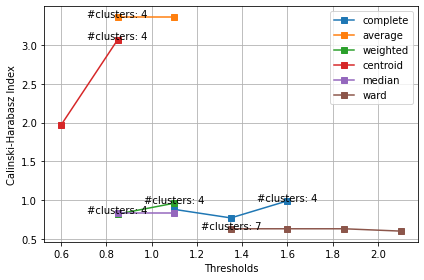

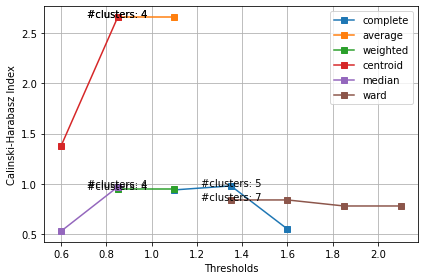

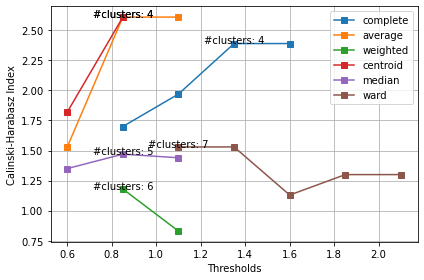

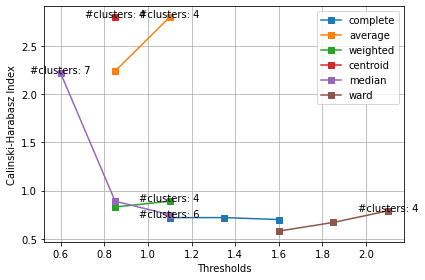

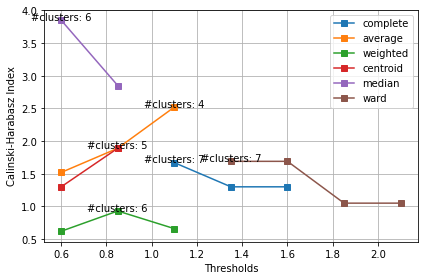

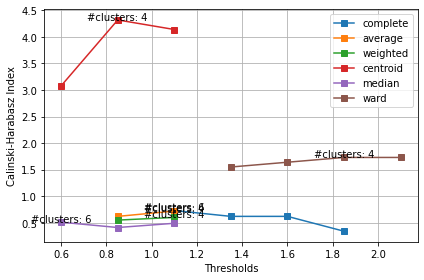

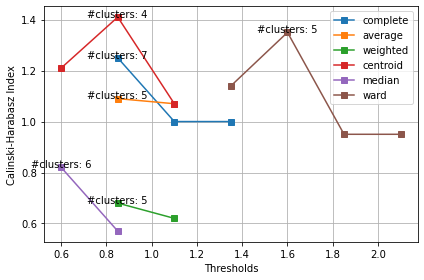

In [38]:
best_values_all_October = []
for n in [str(z).zfill(2) for z in range(0, 7)]:
     with open(f"../October/ET_O{n}.csv", 'r') as f:
        df = preprocess(f)
        dist_mat = get_distance_matrix(df)
        calinski_dict = get_calinski_dict(dist_mat)
        best_values = plot_CalinskiIndex(calinski_dict)
        best_values_all_October.append(best_values)

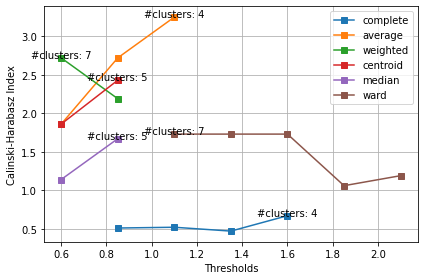

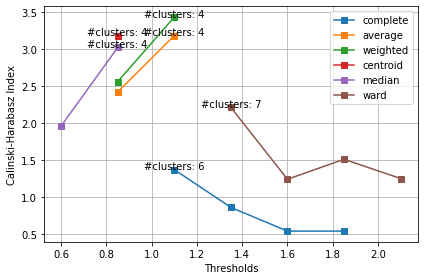

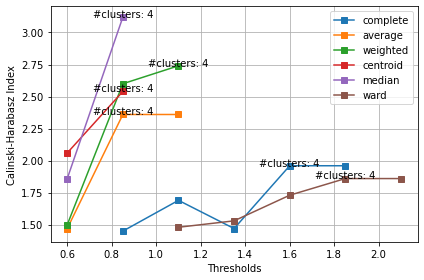

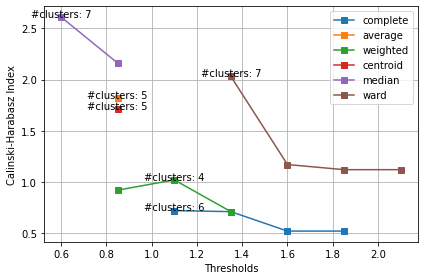

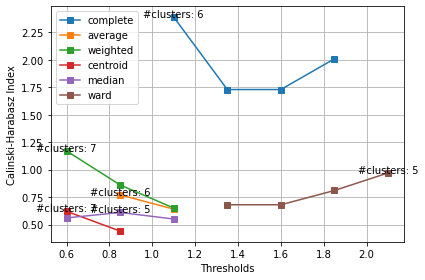

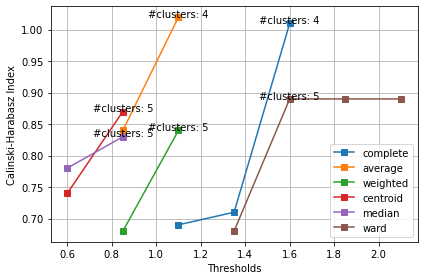

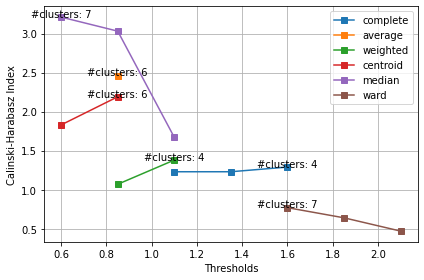

In [42]:
best_values_all_July = []
for n in [str(z).zfill(2) for z in range(0, 7)]:
     with open(f"../July/ET_J{n}.csv", 'r') as f:
        df = preprocess(f)
        dist_mat = get_distance_matrix(df)
        calinski_dict = get_calinski_dict(dist_mat)
        best_values = plot_CalinskiIndex(calinski_dict)
        best_values_all_July.append(best_values)

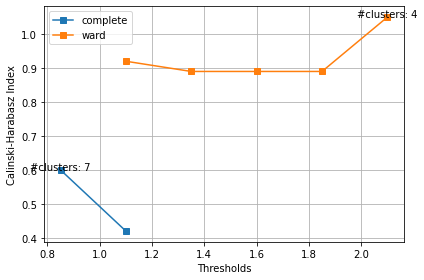

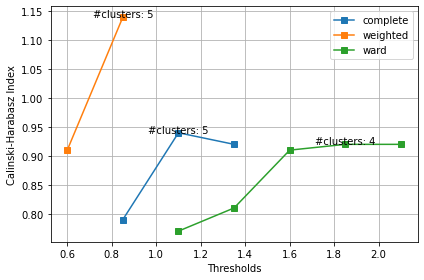

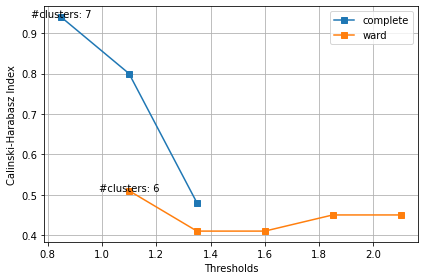

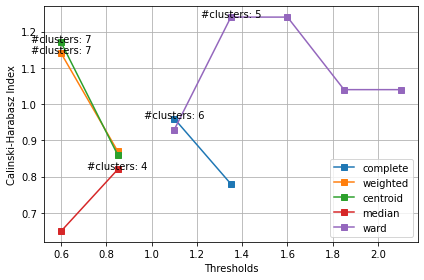

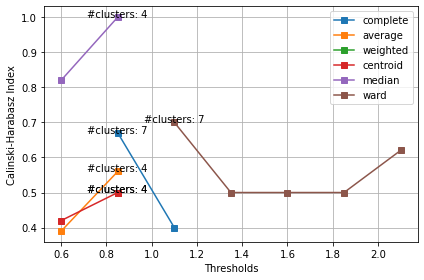

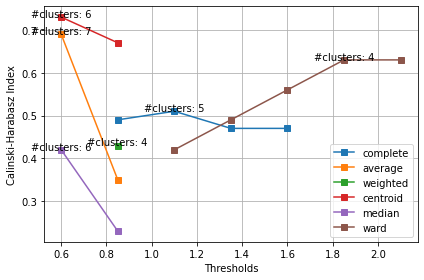

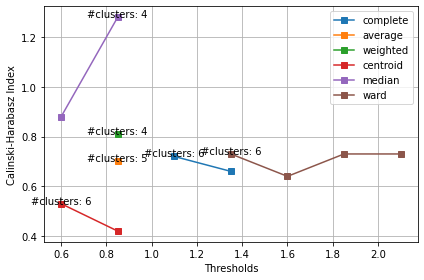

In [59]:
best_values_all_July_VI = []
for n in [str(z).zfill(2) for z in range(0, 7)]:
     with open(f"../July/VI_J{n}.csv", 'r') as f:
        df = preprocess(f)
        dist_mat = get_distance_matrix(df)
        calinski_dict = get_calinski_dict(dist_mat)
        best_values = plot_CalinskiIndex(calinski_dict)
        best_values_all_July_VI.append(best_values)

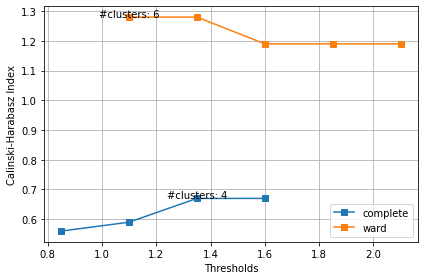

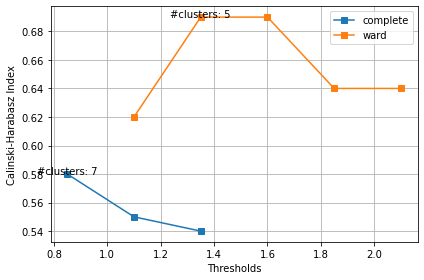

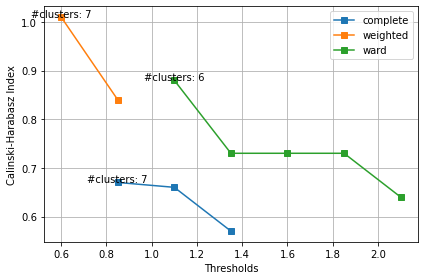

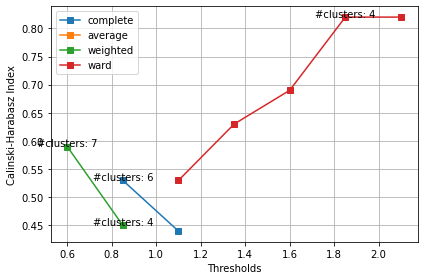

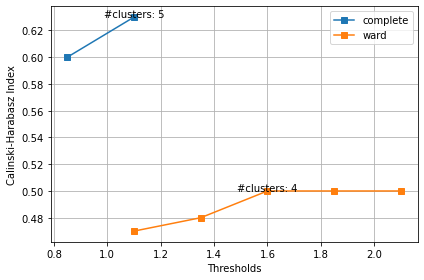

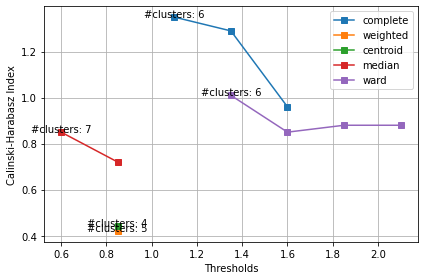

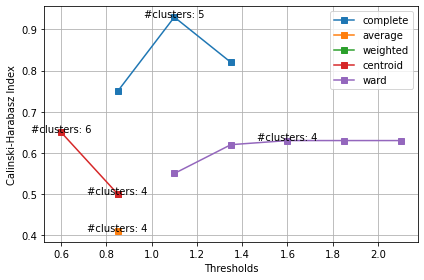

In [60]:
best_values_all_October_VI = []
for n in [str(z).zfill(2) for z in range(0, 7)]:
     with open(f"../October/VI_O{n}.csv", 'r') as f:
        df = preprocess(f)
        dist_mat = get_distance_matrix(df)
        calinski_dict = get_calinski_dict(dist_mat)
        best_values = plot_CalinskiIndex(calinski_dict)
        best_values_all_October_VI.append(best_values)

In [44]:
clustering_methods_statastics(best_values_all_October) 

['average'] : 2
['average', 'centroid'] : 2
['median'] : 1
['centroid'] : 2


In [61]:
clustering_methods_statastics(best_values_all_October_VI) 

['ward'] : 3
['weighted'] : 1
['complete'] : 3


In [45]:
clustering_methods_statastics(best_values_all_July)

['average'] : 2
['weighted'] : 1
['median'] : 3
['complete'] : 1


In [62]:
clustering_methods_statastics(best_values_all_July_VI)

['ward'] : 2
['weighted'] : 1
['complete'] : 1
['median'] : 2
['centroid'] : 1


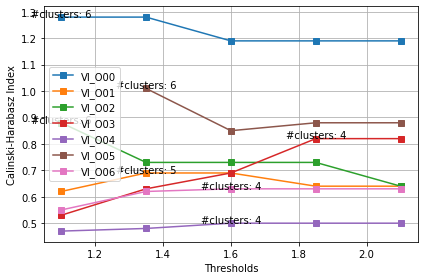

In [63]:
linkage_method = 'ward'
calinski_dict = {}
thresholds = np.linspace(0.6,2.1,7)
for n in [str(z).zfill(2) for z in range(0, 7)]:
     with open(f"../October/VI_O{n}.csv", 'r') as f:
        df = preprocess(f)
        dist_mat = get_distance_matrix(df)
        thr_dict = {}
        for thr in thresholds:
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            if (len(np.unique(group['leaves_color_list'])) > 3):
                dict_temp = {}
                dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
                dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
                thr_dict[thr] =  dict_temp
            else :
                   break
        calinski_dict[f"VI_O{n}"] = thr_dict

best_values = {}

for inkm,data in calinski_dict.items():
    if len(data)>1:
        temp_list = []
        for thr, v in data.items():
            if v['Number of clusters: '] < 8:
                temp_list.append((thr,v['Calinski-Harabasz Index: ']))
        x, y = zip(*temp_list) 
        plt.plot(x, y,'-s', label = inkm)
        max_y = max(y)
        index = y.index(max_y)
        cln = np.squeeze([v['Number of clusters: ']for thr, v in data.items() if thr == x[index]])
        plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')
        #plt.plot(x[index],max_y,'*')
        plt.legend()
        plt.xlabel('Thresholds')
        plt.ylabel('Calinski-Harabasz Index')
        #plt.title('Thresholds')
        plt.grid(True)
        plt.tight_layout()
        best_values[inkm]= (x[index],max_y)

plt.show()


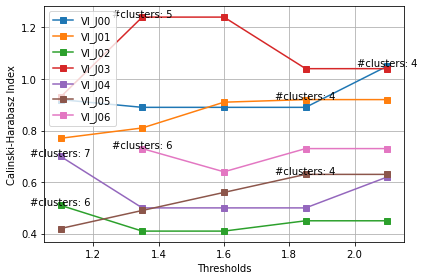

In [64]:
linkage_method = 'ward'
calinski_dict = {}
thresholds = np.linspace(0.6,2.1,7)
for n in [str(z).zfill(2) for z in range(0, 7)]:
     with open(f"../July/VI_J{n}.csv", 'r') as f:
        df = preprocess(f)
        dist_mat = get_distance_matrix(df)
        thr_dict = {}
        for thr in thresholds:
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            if (len(np.unique(group['leaves_color_list'])) > 3):
                dict_temp = {}
                dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
                dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
                thr_dict[thr] =  dict_temp
            else :
                   break
        calinski_dict[f"VI_J{n}"] = thr_dict

best_values = {}

for inkm,data in calinski_dict.items():
    if len(data)>1:
        temp_list = []
        for thr, v in data.items():
            if v['Number of clusters: '] < 8:
                temp_list.append((thr,v['Calinski-Harabasz Index: ']))
        x, y = zip(*temp_list) 
        plt.plot(x, y,'-s', label = inkm)
        max_y = max(y)
        index = y.index(max_y)
        cln = np.squeeze([v['Number of clusters: ']for thr, v in data.items() if thr == x[index]])
        plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')
        #plt.plot(x[index],max_y,'*')
        plt.legend()
        plt.xlabel('Thresholds')
        plt.ylabel('Calinski-Harabasz Index')
        #plt.title('Thresholds')
        plt.grid(True)
        plt.tight_layout()
        best_values[inkm]= (x[index],max_y)

plt.show()
